# TSMC-Net Confusion Matrices
RSAT=0.01 and 90 spectra per class

In [32]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images



import matplotlib.font_manager as fm
font_names = [f.name for f in fm.fontManager.ttflist]
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_global_generator(42)

tf.random.set_seed(42)  

# tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)

from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names
from oneida_utils import simple_spectrum_fig, simple_plot_raw_scores, plot_spectrum_with_scores, multiclass_roc_auc_score, multiclass_sensitivity_specificity_score, multiclass_sensitivity_threshold_score
from oneida_scoring_tools import calc_AMCAS, is_cui_present, is_cui_present_in_mult
from aimos.misc.utils import classifier_internals
from aimos.misc.utils import clf_post_processor
from oneida_utils import mixture_names_to_one_hot_encode
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from oneida_grad_cam import grad_cam



from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm as col_map
from matplotlib import colors

from stats import stats
stats(n_compounds=8)

Total 1-C combinations: 8
Total 2-C combinations: 28
Total 3-C combinations: 56
Total 4-C combinations: 70
Total 5-C combinations: 56
Total 6-C combinations: 28
Total 7-C combinations: 8
Total 8-C combinations: 1
Total combinations: 255


# Retrieve training(D)+ validation(V) mixtures and its variables

In [3]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print('reduced_labels', reduced_labels)


# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

final_neuron_number = np.unique(y, axis=0).shape[0]
print('Number of neurons in the final layer :', final_neuron_number)

print('labels from class:', m.labels)

Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
reduced_labels ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']
Number of neurons in the final layer : 255
labels from class: ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


# preview one test mixture spectra using simple plotter

In [4]:
# idx = 239
# simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
#                    majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
#                    labelpad=4,fontsize='medium',fontweight='bold',
#                   xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

# print(y_concentrations[idx])
# print(reduced_labels)

In [5]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
# print(mixture_types)

In [6]:
mixture_types[19]
mixture_types.tolist().index('$CH_3CHO$')

0

In [7]:
# le.transform(mixture_types)

In [8]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_val shape: (9180, 229, 1)
y_ohe_val shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [9]:
from oneida_model import get_callbacks, get_optimizer, compile_and_fit, TSMCN_12_L_229

In [10]:
model_name = data_filename.split('.pkl')[0].split('/')[1]
print(model_name)

TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90


In [11]:
#Sklearn model saving and loading
from joblib import dump, load

In [12]:
model = tf.keras.models.load_model('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09.hdf5', compile=False)


2022-11-29 21:47:54.626711: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 21:47:54.626842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 21:47:54.626932: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-29 21:47:54.629666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuso

In [18]:
# model.save('model/' + model_name + '_' + dt_string + '.hdf5')
history=np.load('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09history.npy',allow_pickle='TRUE').item()
epochs=np.load('model/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_20-10-2022_time_23-30-09epoch.npy',allow_pickle='TRUE')



In [19]:
# import pandas as pd
# import numpy as np
# import dataframe_image as dfi
# df = pd.DataFrame(np.random.randn(6, 6), columns=list('ABCDEF'))
# df_styled = df.style.background_gradient() #adding a gradient based on values in cell
# # dfi.export(df_styled,"mytable.png")

In [20]:
# df_styled = df.style.background_gradient() #adding a gradient based on values in cell
# # dfi.export(df_styled,"mytable.png")


In [21]:
DF_loss_acc = pd.DataFrame()

DF_loss_acc['epochs'] = epochs
DF_loss_acc['accuracy'] =history['accuracy']
DF_loss_acc['val_accuracy'] =history['val_accuracy']
DF_loss_acc['SparseCatCrossentropy'] =history['SparseCatCrossentropy']
DF_loss_acc['val_SparseCatCrossentropy'] =history['val_SparseCatCrossentropy']

In [22]:
print('Last seven epochs')
print(DF_loss_acc.to_latex())

Last seven epochs
\begin{tabular}{lrrrrr}
\toprule
{} &  epochs &  accuracy &  val\_accuracy &  SparseCatCrossentropy &  val\_SparseCatCrossentropy \\
\midrule
0 &       0 &  0.974510 &      0.961547 &               0.083204 &                   0.124058 \\
1 &       1 &  0.982789 &      0.970370 &               0.053937 &                   0.100376 \\
2 &       2 &  0.974437 &      0.963399 &               0.079185 &                   0.118154 \\
3 &       3 &  0.977778 &      0.972004 &               0.078842 &                   0.105825 \\
4 &       4 &  0.969136 &      0.955447 &               0.097368 &                   0.163062 \\
5 &       5 &  0.969717 &      0.958061 &               0.099299 &                   0.160846 \\
6 &       6 &  0.971387 &      0.971351 &               0.098798 &                   0.085269 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_905509/3042879303.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(DF_loss_acc.to_latex())


In [23]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_val)
pred_y=np.argmax(model.predict(x_val), axis=-1)


287/287 [==============================] - 1s 3ms/step


In [24]:

y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')
y_train_ohe = y_ohe[train_indices]
y_val_ohe = y_ohe[val_indices]
y_train_ohe_tensor = tf.convert_to_tensor(y_train_ohe, np.int64)
y_val_ohe_tensor = tf.convert_to_tensor(y_val_ohe, np.int64)

y_val_named = mixture_types[y_val] # array consisting of string names of validation mixtures

y_train_named = mixture_types[y_train]

pred_y_named = mixture_types[pred_y] # array consisting of string names of predicted mixtures



In [26]:
classifier_internals(pred_y, y_val, y_train, 'val-tsmce-net-style')

---------------------------- val-tsmce-net-style -------------------------------
Fraction Correct[Accuracy]:
0.9713507625272331
Samples Correctly Classified:
(array([   0,    1,    2, ..., 9177, 9178, 9179]),)
Samples Incorrectly Classified:
(array([  10,   72,   94,  124,  133,  171,  177,  185,  192,  217,  230,
        259,  298,  323,  371,  398,  417,  468,  482,  485,  506,  559,
        567,  623,  631,  690,  788,  794,  845,  883, 1019, 1049, 1083,
       1089, 1091, 1146, 1214, 1279, 1290, 1294, 1320, 1338, 1380, 1400,
       1403, 1420, 1458, 1543, 1550, 1562, 1569, 1571, 1670, 1710, 1744,
       1757, 1783, 1791, 1804, 1806, 1816, 1836, 1895, 1920, 1957, 1959,
       2050, 2080, 2082, 2084, 2197, 2206, 2210, 2245, 2341, 2350, 2352,
       2412, 2447, 2471, 2532, 2544, 2589, 2607, 2661, 2709, 2721, 2749,
       2752, 2762, 2796, 2803, 2834, 2835, 2888, 2915, 2984, 2990, 3022,
       3040, 3083, 3118, 3129, 3136, 3200, 3209, 3259, 3277, 3301, 3303,
       3322, 3424, 3434, 34

In [27]:
# y_val_ohe = concentrations_to_one_hot_encode(y_concentrations[val_indices]).astype('int64')

pred_y_ohe = mixture_names_to_one_hot_encode(pred_y_named, reduced_labels, verbosity = False)



# validation spectra

pred: $CH_3CHO$+$CH_3OH$+$H_2CO$+$HCOOH$
actual: $CH_3CHO$+$CH_3OH$+$H_2CO$+$HCOOH$
[[[4570    2]
  [   2 4606]]

 [[4520   52]
  [   6 4602]]

 [[4560   12]
  [  12 4596]]

 [[4565    7]
  [   9 4599]]

 [[4566    6]
  [  16 4592]]

 [[4532   40]
  [  19 4589]]

 [[4563    9]
  [  79 4529]]

 [[4568    4]
  [   8 4600]]]


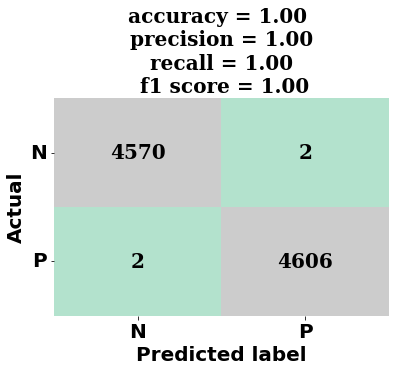

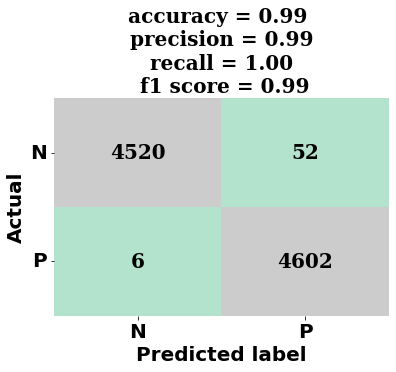

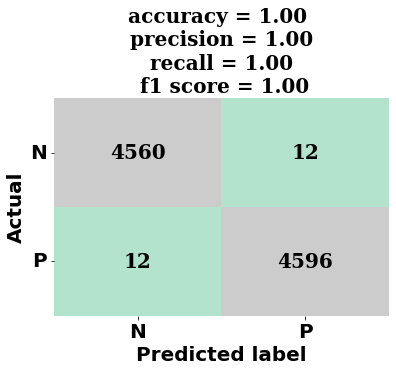

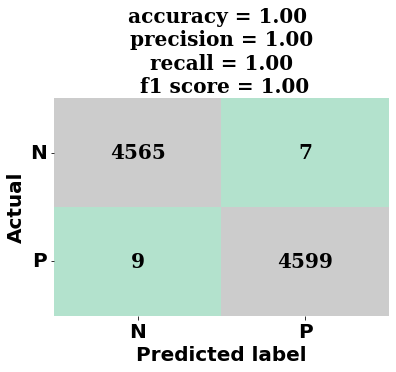

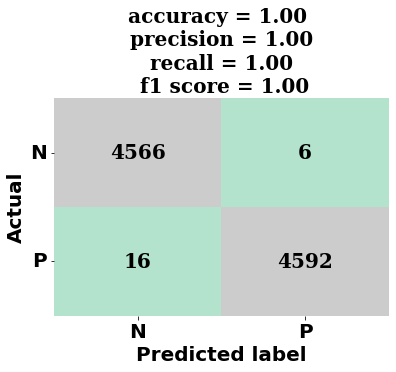

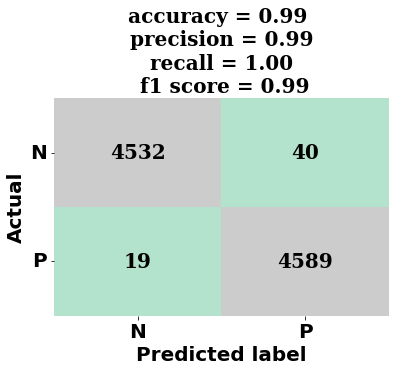

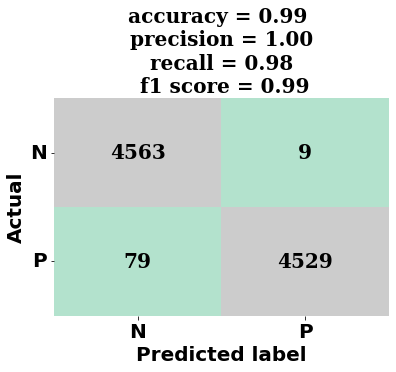

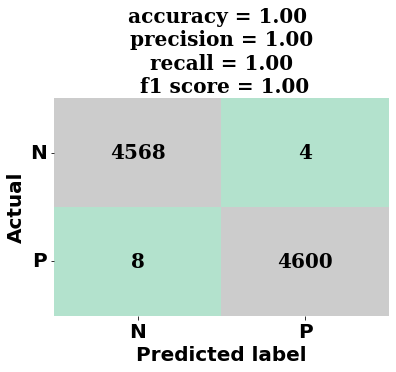

In [31]:



print('pred:',  pred_y_named[11])
print('actual:', y_val_named[11])
print(multilabel_confusion_matrix(y_val_ohe, pred_y_ohe))

plt.rc('font', weight='bold')
labelpad=4
fontsize=20
fontweight='bold'

# f, axes = plt.subplots(2, 4, figsize=(25, 15), dpi=300)

# axes = axes.ravel()
display_labels=['N', 'P']
for i in range(8):
    acc_scr = accuracy_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    prc_scr = precision_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    rec_scr = recall_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    f1_scr = f1_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    
    cm = confusion_matrix(y_val_ohe[:, i], pred_y_ohe[:, i])
#     cmap = sns.diverging_palette(20, 98, sep=10, as_cmap=True)
    cmap = 'Pastel2'

    
    fig = plt.figure();
#     plottitle = f'{reduced_labels[i]} \n accuracy = {acc_scr:.2f} \n precision = {prc_scr:.2f} \n recall = {rec_scr:.2f} \n f1 score = {f1_scr:.2f}'
    plottitle = f'accuracy = {acc_scr:.2f} \n precision = {prc_scr:.2f} \n recall = {rec_scr:.2f} \n f1 score = {f1_scr:.2f}'
    plt.title(plottitle, font='serif', fontsize = fontsize, fontweight = 'bold');
    ax = sns.heatmap(cm, annot=True, annot_kws={'size': fontsize, 'font':'serif', 'fontweight': 'bold', 'color': 'Black'}, fmt='g', cmap=cmap, cbar=False, cbar_kws={'orientation': 'vertical'} );   #cmap='coolwarm' also good
    #ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
    ax.set_xticklabels(display_labels, fontsize = fontsize, fontweight = 'bold');
    ax.set_yticklabels(display_labels, fontsize = fontsize, fontweight = 'bold');
    plt.xlabel('Predicted label', fontsize = fontsize, fontweight = 'bold');
    plt.ylabel('Actual', fontsize = fontsize, fontweight = 'bold');
    plt.xticks(rotation=0);
    plt.yticks(rotation=0);
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=fontsize)
    
    fig.savefig(r'RESULTS/results_figures/' + model_name + '_cm_bin_val_' + reduced_labels[i]  + '.png', bbox_inches='tight')

#     print(classification_report(test_y, pred_y))

In [33]:
# testing spectra (SNR = 30)

In [34]:
# initialize
TAAT = 0.001 
ASAT=0.01
RSAT=0.01

SNR=30
m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print('reduced_labels', reduced_labels)


# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.01_20-10-2022_time_23-16-29_class_cnt_90_SNR_30.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

final_neuron_number = np.unique(y, axis=0).shape[0]
print('Number of neurons in the final layer :', final_neuron_number)

print('labels from class:', m.labels)

Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.01
reduced_labels ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']
Number of neurons in the final layer : 255
labels from class: ['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [35]:
print('Checking original indices')
print(val_indices)

Checking original indices
[2957, 7317, 12991, 13463, 3461, 3855, 18435, 16062, 9572, 17072, 7924, 4866, 15906, 17227, 11510, 2009, 20561, 13503, 13356, 21338, 21522, 788, 5765, 10562, 3751, 8878, 7532, 14517, 10252, 7624, 10851, 5358, 10992, 5896, 12040, 20628, 13459, 15939, 6844, 10310, 18037, 4811, 3126, 9922, 15181, 13913, 1541, 5771, 2586, 1041, 859, 17992, 11887, 21202, 14083, 19237, 8775, 2959, 4144, 15889, 19248, 3562, 18498, 794, 9460, 13811, 22698, 22364, 6521, 133, 21804, 1984, 15406, 13340, 15844, 19735, 20881, 22174, 3439, 20562, 19039, 7248, 15109, 1440, 21237, 22944, 10166, 11372, 13086, 17341, 5790, 6414, 1050, 10042, 4560, 6727, 3880, 7932, 8491, 3336, 3738, 2035, 9157, 7407, 7378, 6908, 12493, 5783, 6096, 10155, 18613, 20157, 7666, 12466, 3629, 507, 12994, 4463, 16599, 21195, 22407, 20859, 20877, 14474, 13565, 3864, 22818, 5649, 17078, 13581, 14984, 15892, 7704, 3798, 3775, 7854, 18877, 5670, 20580, 8951, 15011, 14635, 22801, 17440, 4377, 21035, 10729, 15984, 22905, 54

In [36]:
X.shape
y.shape

(22950,)

In [37]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 22950)
X_train shape: (13770, 229, 1)
y_ohe_train shape: (13770,)
X_val shape: (9180, 229, 1)
y_ohe_val shape: (9180,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [38]:
print('Checking original indices')
print(val_indices)

Checking original indices
[2957, 7317, 12991, 13463, 3461, 3855, 18435, 16062, 9572, 17072, 7924, 4866, 15906, 17227, 11510, 2009, 20561, 13503, 13356, 21338, 21522, 788, 5765, 10562, 3751, 8878, 7532, 14517, 10252, 7624, 10851, 5358, 10992, 5896, 12040, 20628, 13459, 15939, 6844, 10310, 18037, 4811, 3126, 9922, 15181, 13913, 1541, 5771, 2586, 1041, 859, 17992, 11887, 21202, 14083, 19237, 8775, 2959, 4144, 15889, 19248, 3562, 18498, 794, 9460, 13811, 22698, 22364, 6521, 133, 21804, 1984, 15406, 13340, 15844, 19735, 20881, 22174, 3439, 20562, 19039, 7248, 15109, 1440, 21237, 22944, 10166, 11372, 13086, 17341, 5790, 6414, 1050, 10042, 4560, 6727, 3880, 7932, 8491, 3336, 3738, 2035, 9157, 7407, 7378, 6908, 12493, 5783, 6096, 10155, 18613, 20157, 7666, 12466, 3629, 507, 12994, 4463, 16599, 21195, 22407, 20859, 20877, 14474, 13565, 3864, 22818, 5649, 17078, 13581, 14984, 15892, 7704, 3798, 3775, 7854, 18877, 5670, 20580, 8951, 15011, 14635, 22801, 17440, 4377, 21035, 10729, 15984, 22905, 54

In [39]:
predictions = probability_model.predict(x_val)
pred_y=np.argmax(model.predict(x_val), axis=-1)


287/287 [==============================] - 1s 3ms/step


In [40]:

y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')
y_train_ohe = y_ohe[train_indices]
y_val_ohe = y_ohe[val_indices]
y_train_ohe_tensor = tf.convert_to_tensor(y_train_ohe, np.int64)
y_val_ohe_tensor = tf.convert_to_tensor(y_val_ohe, np.int64)

y_val_named = mixture_types[y_val] # array consisting of string names of validation mixtures

y_train_named = mixture_types[y_train]

pred_y_named = mixture_types[pred_y] # array consisting of string names of predicted mixtures



In [42]:
# classifier_internals(pred_y, y_val, y_train, 'test-tsmc-net-style')

In [43]:
# y_val_ohe = concentrations_to_one_hot_encode(y_concentrations[val_indices]).astype('int64')

pred_y_ohe = mixture_names_to_one_hot_encode(pred_y_named, reduced_labels, verbosity = False)



pred: $C_2H_5OH$+$CH_3CHO$+$CH_3OH$+$H_2CO$+$HCOOH$
actual: $CH_3CHO$+$CH_3OH$+$H_2CO$+$HCOOH$
[[[3908  664]
  [ 622 3986]]

 [[3990  582]
  [  61 4547]]

 [[4002  570]
  [ 101 4507]]

 [[4186  386]
  [  28 4580]]

 [[3935  637]
  [ 214 4394]]

 [[3294 1278]
  [ 302 4306]]

 [[3738  834]
  [ 980 3628]]

 [[4144  428]
  [ 117 4491]]]


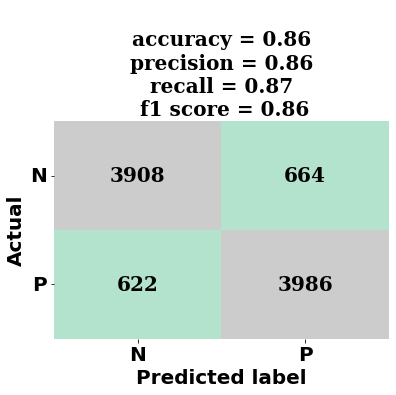

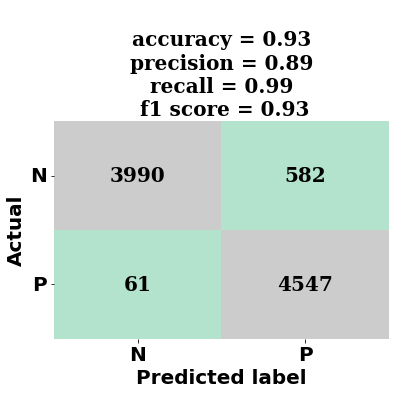

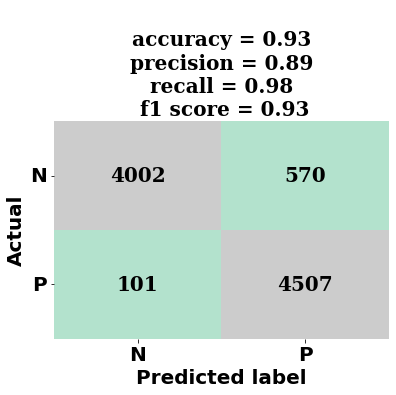

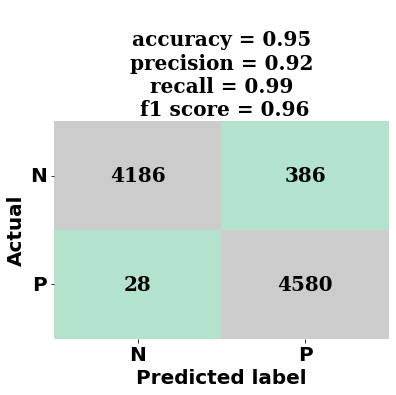

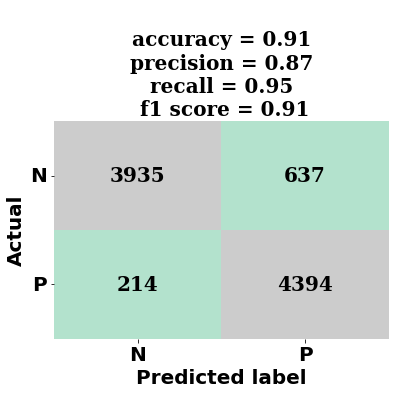

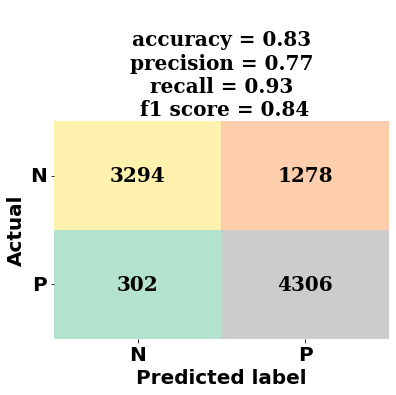

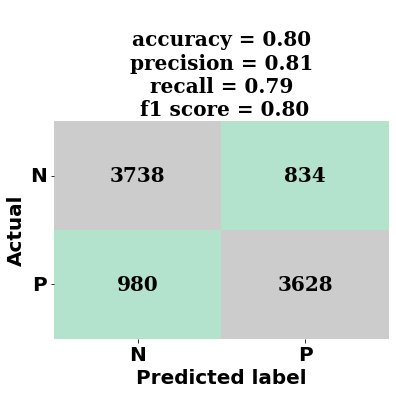

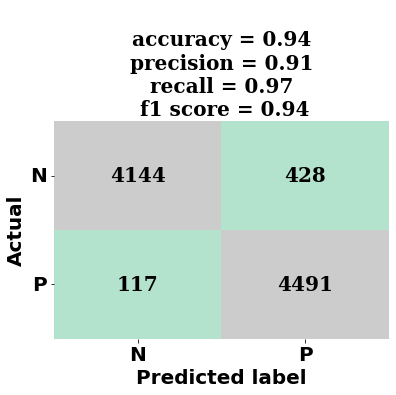

In [45]:
print('pred:',  pred_y_named[11])
print('actual:', y_val_named[11])
print(multilabel_confusion_matrix(y_val_ohe, pred_y_ohe))

plt.rc('font', weight='bold')
labelpad=4
fontsize=20
fontweight='bold'

# f, axes = plt.subplots(2, 4, figsize=(25, 15), dpi=300)

# axes = axes.ravel()
display_labels=['N', 'P']
for i in range(8):
    acc_scr = accuracy_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    prc_scr = precision_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    rec_scr = recall_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    f1_scr = f1_score(y_val_ohe[:, i], pred_y_ohe[:, i]);
    
    cm = confusion_matrix(y_val_ohe[:, i], pred_y_ohe[:, i])
    cmap = sns.diverging_palette(20, 98, sep=10, as_cmap=True)
    cmap = 'Pastel2'

    
    fig = plt.figure();
#     plottitle = f'{reduced_labels[i]} \n accuracy = {acc_scr:.2f} \n precision = {prc_scr:.2f} \n recall = {rec_scr:.2f} \n f1 score = {f1_scr:.2f}'
    plottitle = f'\n accuracy = {acc_scr:.2f} \n precision = {prc_scr:.2f} \n recall = {rec_scr:.2f} \n f1 score = {f1_scr:.2f}'
    plt.title(plottitle, font='serif', fontsize = fontsize, fontweight = 'bold');
    ax = sns.heatmap(cm, annot=True, annot_kws={'size': fontsize, 'font':'serif', 'fontweight': 'bold', 'color': 'black'}, fmt='g', cmap=cmap, cbar=False, cbar_kws={'orientation': 'vertical'} );   #cmap='coolwarm' also good
    #ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage
    ax.set_xticklabels(display_labels, fontsize = fontsize, fontweight = 'bold');
    ax.set_yticklabels(display_labels, fontsize = fontsize, fontweight = 'bold');
    plt.xlabel('Predicted label', fontsize = fontsize, fontweight = 'bold');
    plt.ylabel('Actual', fontsize = fontsize, fontweight = 'bold');
    plt.xticks(rotation=0);
    plt.yticks(rotation=0);
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=fontsize)
    
    fig.savefig(r'RESULTS/results_figures/' + model_name + '_cm_bin_val_' + reduced_labels[i]  + '_SNR=30.png', bbox_inches='tight')

#     print(classification_report(test_y, pred_y))

notebook ends!